# (Test) Finding required time-shift using cross-correlation
Programmed by: Elvis

This will find the best time-shift in order to get the same start and end points between two sets of data with one being the main set to compare against

# Acceleration Data Processor Version 2.0
Programed by: Sean, Yijia, Elvis

## How to use
1. Make sure all the required packages are installed
    * Run the following command to install if you haven't: ```pip install pandas matplotlib xlrd scipy notebook```
2. If you are seeing this, you are already running jupyter notebook
3. To run this program, navigate to:
    1. Menu Bar >
    2. Kernel >
    3. Restart & Run All
4. Follow the prompts at the bottom of this notebook

# 1) Import modules

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import csv
import os.path
import matplotlib.pyplot as plt
from scipy.signal import lfilter
import openpyxl
import glob
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.utils import column_index_from_string
import math

# 2) Formatting the specified raw data provided in .csv format 

## Auxiliary Functions

```getInputForColumns()```
Returns a list with column ids as Strings.
    
The elements are column ids in A1 format and are set as follows:\
[Time-stamp, Acceleration X, Acceleration Y, Accelerationz]

Function parameters:\
None

In [2]:
def getInputForColumns():
    """Returns a list with column ids as Strings.
    
    The elements are column ids in A1 format and are set as follows:
    [Time-stamp, Acceleration X, Acceleration Y, Acceleration Z]
    """
    
    # Get input for the columns
    interval = 0
    startIndex = 0
    column_ids = ["", "", "", ""]
    buffer = ""
    isFinal = False
    excel_wb_name = ""
    
    while (isFinal == False):
        print("Enter the row number to start data input (0 for first row I.e. Your file has no headers): ")
        startIndex = int(input("Start Index: "))
        print("Enter the row interval for acceleration (if each row is the reading for acceleration, just enter 1): ")
        interval = int(input("Row Interval: "))
        print("Enter the Column ID in A1 format (e.g. A, B, C) for the following items:")
        buffer = input("Time-stamp: ")
        column_ids[0] = buffer
        buffer = input("Acceleration X: ")
        column_ids[1] = buffer
        buffer = input("Acceleration Y: ")
        column_ids[2] = buffer
        buffer = input("Acceleration Z: ")
        column_ids[3] = buffer
        excel_wb_name = input("An excel workbook will be created. Please input your preferred name (CASE-SENSITIVE): ")
        buffer = input("Confirm entry? [Y]/[N]: ")
        if (buffer.lower() == "y"):
            isFinal = True
            print("File is running...")
            
    
    return startIndex, interval, column_ids, excel_wb_name

```a1ToIndex```
Converts the Supplied Column ID in A1 format to a Normal Index starting from 0
    
Function parameters:\
(String) a1 -- Column ID in String Format

In [3]:
def a1ToIndex(a1, isZeroIndex):
    """Converts the Supplied Column ID in A1 format to a Normal Index starting from 0
    
    Function parameters:
    (String) a1 -- Column ID in String Format
    (Bool) isZeroIndex -- First column starts from '0' if set to True
    """
    assert type(a1) is str, "Expected a String"
    assert type(isZeroIndex) is bool, "Expected a Boolean"
    return column_index_from_string(a1) - int(isZeroIndex)*1

## Filters, Creates new csv, and Converts to Pandas Data Frames

|**Parameter**|**Description**|**Variable Used**|**Description**|
|:-|:-|:-|:-|
|```file_name```|the name of the file (in string)|```formatted```|the csv file generated and one where filtering is applied to|
|```title```|name of the file|```df```|the DataFrame generated from the formatted csv file|
|```output_path```|the path for output| |


In [4]:
def csv2df(file_name, title, output_path):
    '''filter the csv file & import to DataFrame'''
    formatted_output_path = output_path + "/" + title + "-formatted.csv"
    
    # Get the column ids where the required data is located from the user
    startIndex, interval, column_ids, excel_wb_name = getInputForColumns()
    # Transform the user input in A1 format into index for use later
    # [0: Time-stamp, 1: Acceleration X, 2: Acceleration Y, 3: Acceleration Z]
    column_indexes = [a1ToIndex(colID, True) for colID in column_ids]
    
    # Opens the given file
    my_file = open(file_name)
    
    # Creates a clean csv file for output
    formatted = open(formatted_output_path,"w",newline='')
    
    # Sets this as csv
    reader = csv.reader(my_file)
    formatted_csv = csv.writer(formatted)
    
    # Create a header in formatted.
    header = ['TimeStamp','TimeElapsed','Category','Acc-X','Acc-Y','Acc-Z']
    formatted_csv.writerow(header)
    
    # Start filtering
    i = 0 #initial value for the index, used for mapping
    for item in reader:
        if ((i-startIndex) >= 0) & (((i - startIndex) % interval) == 0):
            each_line = []
            for column_index in column_indexes:
                try:
                    each_line.append(item[column_index])
                except:
                    pass # To prevent the code from stopping if some cells are blank
            each_line.insert(1,0)
            each_line.insert(2,"Acceleration")
            formatted_csv.writerow(each_line)
            i += 1
        else:
            i += 1
            
    # Closes the given file
    my_file.close()
    
    # Change to Dataframe in pandas
    df = pd.read_csv(formatted_output_path,header = 0)   

    return df

In [5]:
def csv_to_excel(d, output_path, is_ms):
    '''
    Input: A dictionary of .csv file names, title of file name
    Output: Data imported into excel workbook
    '''
    
    # Create new Excel workbook
    wb = openpyxl.Workbook()
    # Just to remove the spare sheet
    wb.remove(wb.active)
    # Get the column ids where the required data is located from the user
    startIndex, interval, column_ids, excel_wb_name = getInputForColumns()
    # Transform the user input in A1 format into index for use later
    # [0: Time-stamp, 1: Acceleration X, 2: Acceleration Y, 3: Acceleration Z]
    column_indexes = [a1ToIndex(colID, True) for colID in column_ids]

    
    # For each key in dictionary
    for i, key in enumerate(d):
        
#         Concatenate csv files which start and end at same point together
        df_list = []
        for file in d[key]:
            formatted_output_path = output_path + "/" + file + "-formatted.csv"

            

            # Creates a clean csv file for output
            with open(formatted_output_path,"w",newline='') as f:
                with open(f'{file}.csv') as my_file:
            
                    # Sets this as csv
                    reader = csv.reader(my_file)
                    formatted_csv = csv.writer(f)

                    # Create a header in formatted.
                    header = ['TimeStamp','TimeElapsed','Category','Acc-X','Acc-Y','Acc-Z']
                    formatted_csv.writerow(header)

                    # Start filtering
                    i = 0 #initial value for the index, used for mapping
                    for item in reader:                        
                        if ((i-startIndex) >= 0) & (((i - startIndex) % interval) == 0):
                            each_line = []
                            for column_index in column_indexes:
                                try:                                    
                                    each_line.append(item[column_index])
                                except:
                                    pass # To prevent the code from stopping if some cells are blank
                            each_line.insert(1,0)
                            each_line.insert(2,'Acceleration')
                            formatted_csv.writerow(each_line)
                            i += 1
                        else:
                            i += 1
                formatted_df = pd.read_csv(formatted_output_path,header = 0)
                timeElapsed(formatted_df, is_ms)
                #     Convert the respective files into a list of df
                df_list.append(formatted_df)


    #     Concatenate the dfs into 1
        concat_df = pd.concat(df_list, axis = 1)

    #     Create a new column: Average of all acceleration data
        try:
            concat_df['Average Y'] = concat_df['Acc-Y'].mean(axis=1)
        except:
    #         If only have 1 set of readings, still need to create a new column
            concat_df['Average Y'] = concat_df['Acc-Y']
      
    #     Store key as title of file
        title = key

    #     Create ws with the title == key of dictionary
        ws = wb.create_sheet(index=i, title=title)

    #     Import the df into the excel sheet
        for r in dataframe_to_rows(concat_df, index=False, header=True):
            ws.append(r)

#     try:
    excel_wb_name = f"{output_path}/{excel_wb_name}"
    wb.save(f'{excel_wb_name}.xlsx')
    print(f"Excel workbook created at {output_path}")
    return excel_wb_name
#     except:
#         print('''
#         Excel file failed to create. 
#         Please check that the name given does not contain the following special characters:
#         / \ : * ? " < > | ''')

# 3) DataFrame Manipulation

## Function to Generate Time Elapsed

In [6]:
def timeElapsed(df, is_ms): 
    
    # Calculate and write a time_elapsed column
    df['TimeElapsed'] = df['TimeStamp'] - df['TimeStamp'].iloc[0]
    
    if is_ms == 'y':
        df['TimeElapsed'] = df['TimeElapsed'] / 1000

## Function to Generate Time Interval

In [7]:
def retrieve_longest_t_col(df, col):
    '''
    To retrieve the col inputted with the MOST number of rows
    '''
    
# Remove all rows where all values are blank then Retrieve the last value    
    last_value_of_t = df[col].dropna(how='all').iloc[-1]
    t = df[col].dropna(how='all').reset_index(drop=True) # Shift the index back to 0!

# If there's only 1 "Timestamp" in the excel sheet, then our x-axis will just equal to it. 'pass' because values assigned to t already is correct
    if type(last_value_of_t) == float or type(last_value_of_t) == int:
        pass
    else:
# Retrieve index of time that is not 'NaN'. This is equivalent to retrieving maximum time (I.e. Most number of rows)
        time_formatted = [i for i, el in enumerate(list(t.iloc[-1])) if not math.isnan(el)]
        idx = time_formatted[0] # This works because there should only be 1 value that is 'NaN' 
# If there is 2 or more, this means that all the time end at the same row / time which is highly unlikely. Even if it does happen, I will still be retrieving the idx of the max t


# t = Col with most number of rows
        t = t.iloc[:, idx]
    
    return t

In [8]:
def timeInterval(df):
    '''calculate time interval from the TimeElpased column'''
    t = retrieve_longest_t_col(df, col = "TimeElapsed")

    #index of TimeInterval: 6
    
    # Retrieve all rows excluding last & reset the index (Shift it back down to 0)
    next_value = t.iloc[1:].reset_index(drop=True)
    # Find difference
    timeInterval = next_value - t
    # Add '0' value to first row & Format the index again
    timeInterval = pd.concat([pd.Series([0]), timeInterval]).reset_index(drop = True)
    # Apparently, df["TimeInterval"] values start from 1, hence the need for the code below
    timeInterval.index = range(1,len(timeInterval)+1)
    
    df["TimeInterval"] = timeInterval

    

## Function to generate Acc-Y-Adjusted

Variable: <br>
shift_value: the value to shift all acceleration values 
<p> in this application, the shift value from the experiment results, is approximately to be (initial accelration)/2</p>

In [9]:
def accAdjust(df, smoothen_curve, format_acc):
    '''Generate the Acc-Y-Adjusted and take the shift value into account'''
    
    #index of Acc-Y-Adjusted: 7

    if format_acc == 'y':
        df["Average Y"] = df["Average Y"] * -9.81
    acc_Y = df["Average Y"]
#     for i in range(len(df)):
#         acc_Y.append(df.iloc[i,4]*9.8)
        
    # Filter to remove noise
    n = int(smoothen_curve)  # the larger n is, the smoother curve will be
    b = [1.0 / n] * n # b, numerator coefficient vector in a 1-D sequence
    a = 1 # a, denominator coefficient vector in a 1-D sequence
    acc_Y_filtered = lfilter(b,a,acc_Y)
        
    df["Acc-Y-Adjusted"] = acc_Y_filtered
    
    #shift value
    shift_value = df["Acc-Y-Adjusted"] / 2
    df["Acc-Y-Adjusted"] = df["Acc-Y-Adjusted"] - shift_value
#     for i in range(len(df)):
#         df.iloc[i,7] = df.iloc[i,7] - shift_value
    


## Function to generate V-btw2

In [10]:
def dv(df):
    '''Generate the d_v using the definition of integration using the Acc-Y-Adjusted values'''
    #index of V-btw2: 8
    #index7: Acc-Y-Adjusted
    #index6: TimeInterval
    d_v = 0.5 * (df["Acc-Y-Adjusted"].iloc[1:].reset_index(drop=True) + df["Acc-Y-Adjusted"]) * df["TimeInterval"]
    
    df["V-btw2"] = d_v

## Function to generate V(t)

In [11]:
def vt(df):
    '''Generate the v(t) column to record the instantaneous velocity of all data points'''
    
    #index of V(t): 9
    
    false_list = [0]*len(df)
    df["V(t)"] = false_list
    ins_v = [0]
    for i in range(1,len(df)):
    # index8: V-btw2
        ins_v.append(sum(df["V-btw2"].iloc[:i-1]))
    df["V(t)"] = ins_v

## Function to generate S-btw2

In [12]:
def ds(df):
    '''Generate the d_s using the definition of integration using the V(t) values'''
    
    d_s = 0.5 * (df["V(t)"].iloc[1:].reset_index(drop=True) + df["V(t)"]) * df["TimeInterval"]
    
    #index of S-btw2: 10
    df["S-btw2"] = d_s

## Function to generate S(t)

In [13]:
def st(df):
    '''Generate the s(t) column to record the instantaneous displacement of all data points'''
    
    #index of V(t): 11
    false_list = [0]*len(df)
    df["S(t)"] = false_list  
    
    ins_s = [0]
    for i in range(1,len(df)):
    # index8: V-btw2
        ins_s.append(sum(df["S-btw2"].iloc[:i-1]))

    df["S(t)"] = ins_s

## Function to integrate all the functions in this section

In [14]:
def format_headers(df):
    
# Format headers as long as the first row is not a numerical value
# Note: Headers are not considered as the first row
# Note: '.item()' is to convert numpy types to native Python types
    try:
        if type(df.iloc[0, 0].item()) == float:
            pass
    except:
        header = df.iloc[0]
        df = df[1:]
        df.columns = header
    return df

In [15]:
def dfFormat(df, smoothen_curve, format_acc):
    df = format_headers(df)
    timeInterval(df)
    accAdjust(df, smoothen_curve, format_acc)
    dv(df)
    vt(df)
    ds(df)
    st(df)
#     print(df)
    return df

# 4) Physical Property Determination (Data Insights)

## Total Distance Travelled

In [16]:
def distance(df):
    '''Get the total distance travelled'''
    
    Total_Distance_Travelled = max(df["S(t)"])
    
    return Total_Distance_Travelled

## Total Time Taken

In [17]:
def totalTime(df):
    '''Get the total time taken'''
    t = retrieve_longest_t_col(df, col = "TimeElapsed")
    Total_Time_Taken = t.iloc[-1]
    
    return Total_Time_Taken

## Max Velocity

In [18]:
def maxVelocity(df):
    '''Get the max velocity'''
    
    Max_Velocity = max(df["V(t)"])
    
    return Max_Velocity

## Acceleration Cut-off Time & Average Acceleration

Variables: <br>
negative_acc_list: a list of the index of which the acceleration value is nagetive

In [19]:
def acc(df):
    '''Get the cut-off time for acceleration & Average Acceleration'''
    negative_acc_list = df[df["Acc-Y-Adjusted"] < 0].index.tolist()
    # To avoid early cut-off
    # set the threshhold to be 1/4 of total journey
    while negative_acc_list[0] < 0.25*len(df):
        negative_acc_list = negative_acc_list[1:]
        
    CutOff_Time = df.iloc[negative_acc_list[0],1]
    
    cutoff_idx = negative_acc_list[0]
    acc_list = []
    for i in range(cutoff_idx):
        acc_list.append(df["Acc-Y-Adjusted"].iloc[i])
    Average_Acceleration = sum(acc_list)/len(acc_list)
    
    return CutOff_Time, Average_Acceleration

## Max Acceleration

In [20]:
def maxAcc(df):
    '''Get the maxium Acceleration'''
    
    Max_Acceleration = max(df["Acc-Y-Adjusted"])

    return Max_Acceleration

## Function to integrate all the functions in this section

In [21]:
def data(df):
    Total_Distance_Travelled = distance(df)
    Total_Time_Taken = totalTime(df)
    Max_Velocity = maxVelocity(df)
    CutOff_Time, Average_Acceleration = acc(df)
    Max_Acceleration = maxAcc(df)
    
    result_data = f'''
    # Total distance travelled: {Total_Distance_Travelled} m
    # Total time taken (For multiple readings, it is the longest time): {Total_Time_Taken} s
    # Max velocity: {Max_Velocity} m/s
    # Cut-off time for acceleration: {CutOff_Time} s
    # Average acceleration: {Average_Acceleration} m/s^2
    # Max acceleration: {Max_Acceleration} m/s^2
    '''
    
    return result_data

# 5) Generating and Saving Graphs

## Graph a-t

In [22]:
def plotAcc(df,title,CutOff_Time, output_path):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
    axes.set_xlabel('time (s)')
    axes.set_ylabel('Acceleration_y (m/s^2)', color='tab:blue')
    
    t=df["TimeElapsed"]
    acc_y=df["Acc-Y-Adjusted"]
    axes.plot(t,acc_y,color="red", lw=2, ls='-')
    axes.axvline(CutOff_Time, 0, 1, label='Cut-off for acceleration')
    axes.axhline(0, color='black')
    axes.legend()
    axes.title.set_text(title)
    
    name = title + '-'+ 'Acceleration'
    plt.savefig(f'{output_path}/{name}.png')

## Graph v-t

In [23]:
def plotVelocity(df,title,Max_Velocity, output_path):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
    axes.set_xlabel('time (s)')
    axes.set_ylabel('Velocity (m/s)', color='tab:blue')
    
    t=df["TimeElapsed"]
    v=df["V(t)"]
    axes.plot(t,v,color="red", lw=2, ls='-')
    axes.axhline(Max_Velocity, 0, 1, label='Max Velocity')
    axes.legend()
    axes.title.set_text(title)
    
    name = title + '-'+ 'Velocity'
    plt.savefig(f'{output_path}/{name}.png')

## Graph s-t

In [24]:
def plotDisplacement(df,title,Total_Distance_Travelled, output_path):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
    axes.set_xlabel('time (s)')
    axes.set_ylabel('Displacement (m)', color='tab:blue')
    
    t=df["TimeElapsed"]
    s=df["S(t)"]
    axes.plot(t,s,color="red", lw=2, ls='-')
    axes.axhline(Total_Distance_Travelled, 0, 1, label='Total Distance Travelled')
    axes.legend()
    axes.title.set_text(title)
    
    name = title + '-'+ 'Displacement'
    plt.savefig(f'{output_path}/{name}.png')

# 6) Calculating and Generating Output

In [25]:
def mkdir_p(mypath):
    '''Creates a directory. equivalent to using mkdir -p on the command line'''
    if not os.path.exists(mypath):
        os.makedirs(mypath)

In [26]:
def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

def sorted_dict(all_files):
    '''
    Input: Requires a list of .csv files
    Output:
    - A dictionary with values sorted according to the train trip
    - file_names excluding '.csv'
    
    '''

    d = {}

    # Retrieve file_names
    file_names = ''.join(all_files).split('.csv')[:-1]


    for name in file_names:

    # If name of file as a digit, find index of digit
        if hasNumbers(name):

    # Find the index of the digit
            idx = [char.isdigit() for char in name].index(True)

    # Split by the index and store the front end as the key
    # Note: '-1' is to exclude the whitespace as well
            key = name[:idx-1]
            if key in d:
                d[key].append(name)
            else:
                d[key] = [name]
        else:
            if name in d:
                d[name].append(name)
            else:
                d[name] = [name]

    
    return d, file_names


## Run it all (Main function)

In [27]:
def main():
    # User Input
    output_dir = "/" + input("Please input the folder name for output: ") # i.e. "Output-1"
#     file_name = input("Please input the relative/full path to csv file: ") # i.e. "example_data/UC_EXPO_first.csv"
    


    # Setup Output Path
    my_path = os.path.realpath("")
    output_path = my_path + output_dir
    mkdir_p(output_path)
    
    # Create new Excel workbook
    wb = openpyxl.Workbook()
    # Just to remove the spare sheet
    wb.remove(wb.active)

    # Retrieve directory containing all .csv files
    user_dir = input("Please input the path to the directory containing all the .csv files: ")
    path = 'c:\\'
    extension = 'csv'
    os.chdir(user_dir)
    all_files = glob.glob('*.{}'.format(extension))
    d, file_names = sorted_dict(all_files)
      
    print("Results will be available at: {}".format(output_path))

    while True:
        try:
            smoothen_curve = input("Please input a number from 1-15 (A larger number results in a smoother curve but some readings may be missing): ")
            if int(smoothen_curve) in range(1,16):
                pass
            else:
                continue
            format_acc = input("Is your acceleration measured in g? (I.e. '1' represents 9.81ms^-2) [Y]/[N]: ")

            if format_acc.lower() == 'y' or format_acc.lower() == 'n':
                        pass
            else:
                continue
            is_ms = input("Is your time measured in ms? (I.e. '1000' represents 1s) [Y]/[N]: ")
            if is_ms.lower() == 'y' or is_ms.lower() == 'n':
                        break
        except:
            print("Invalid Input. Please try again.")
            continue

#     Reads sorted dict of csv files. Converts them to data frame and concatenate similar ones together. Outputs excel wb
    excel_wb_name = csv_to_excel(d, output_path, is_ms)
    
    # Change back to original directory
    os.chdir(my_path)
    


    
    acceleration_data = pd.read_excel(f'{excel_wb_name}.xlsx', sheet_name=None, header=None)
    
    for i, title in enumerate(acceleration_data):
        print(f"Status: Running {i+1} / {len(acceleration_data)}")
        df = acceleration_data[title]
        # Calculations to get the adjusted acceleration, velocity, and displacement
        df = dfFormat(df, smoothen_curve, format_acc) 

        # Save the DataFrame as the csv file
        formatted_csv_path = output_path + "/" + title + "-formatted.csv"
        df.to_csv(formatted_csv_path)

        # Calculate Data Insights
        result_data = data(df)


        # Save Data Insights to File
        formatted_output_path = output_path + "/" + title + "-insights.txt"
        insights_file = open(formatted_output_path,"w",newline='')
        insights_file.write(result_data)
        insights_file.close()

        # The next three lines are for use in plotting as parameters
        Total_Distance_Travelled = distance(df)
        Max_Velocity = maxVelocity(df)
        CutOff_Time, Average_Acceleration = acc(df)

        # Plot & save data to specified output location
        plotAcc(df,title, CutOff_Time, output_path)
        plotVelocity(df, title, Max_Velocity, output_path)
        plotDisplacement(df, title, Total_Distance_Travelled, output_path)

Please input the folder name for output: ../output/output-test
Please input the path to the directory containing all the .csv files: ../data2
Results will be available at: /home/elviskasonlin/Code/projects/sutd-1d-physicalworld/python/../output/output-test
Please input a number from 1-15 (A larger number results in a smoother curve but some readings may be missing): 15
Is your acceleration measured in g? (I.e. '1' represents 9.81ms^-2) [Y]/[N]: y
Is your time measured in ms? (I.e. '1000' represents 1s) [Y]/[N]: n
Enter the row number to start data input (0 for first row I.e. Your file has no headers): 
Start Index: 1
Enter the row interval for acceleration (if each row is the reading for acceleration, just enter 1): 
Row Interval: 1
Enter the Column ID in A1 format (e.g. A, B, C) for the following items:
Time-stamp: A
Acceleration X: O
Acceleration Y: P
Acceleration Z: Q
An excel workbook will be created. Please input your preferred name (CASE-SENSITIVE): output-test
Confirm entry? [Y]

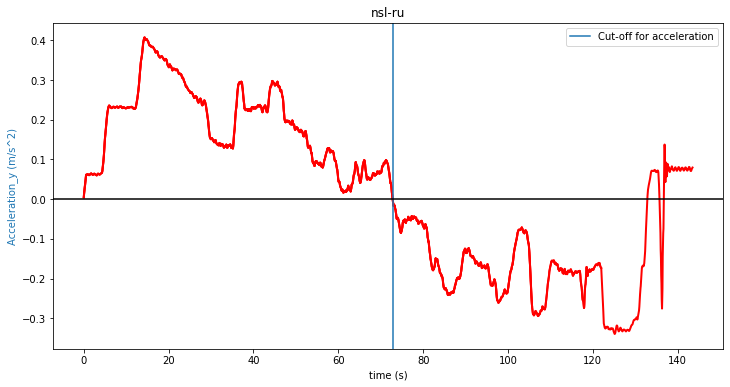

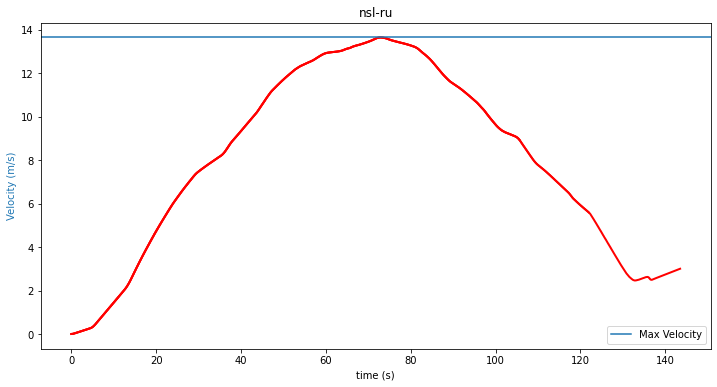

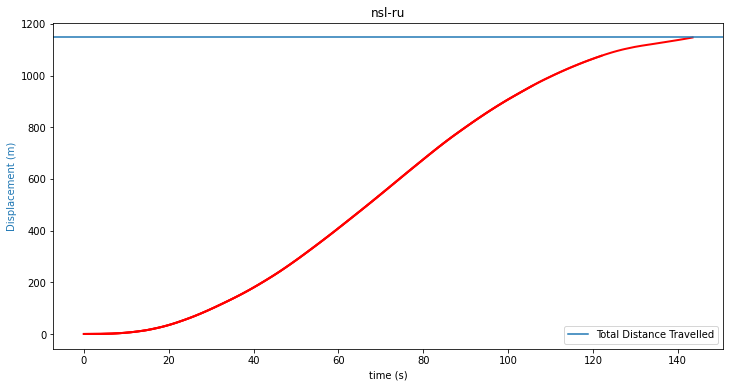

In [29]:
main()